In [ ]:
!pip install tensorflow
!pip install tensorflow matplotlib scikit-learn seaborn

In [ ]:
import tensorflow as tf
import pandas as pd
import numpy as np
import random
import os
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from sklearn.metrics import confusion_matrix, classification_report,accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import VGG16, ResNet101

#**Loading dataset**

In [ ]:
import kagglehub

path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset")

print("Path to dataset files:", path)

path = "/root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1"
train_path = os.path.join(path, 'Training/')
test_path = os.path.join(path, 'Testing/')

classes = [folder for folder in os.listdir(train_path) if os.path.isdir(os.path.join(train_path, folder))]
print("Classes:", classes)

100%|██████████| 149M/149M [00:00<00:00, 221MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/masoudnickparvar/brain-tumor-mri-dataset/versions/1
Classes: ['meningioma', 'glioma', 'notumor', 'pituitary']


#**Data preprocessing**

In [ ]:
image_size = (150, 150)
batch_size = 32

train_datagen = ImageDataGenerator(rescale=1./255, rotation_range=10, brightness_range=(0.85, 1.15),
                                   width_shift_range=0.002, height_shift_range=0.002, shear_range=12.5,
                                   horizontal_flip=True, fill_mode="nearest")

test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(train_path, target_size=image_size, batch_size=batch_size,
                                                    class_mode="categorical", seed=0)

test_generator = test_datagen.flow_from_directory(test_path, target_size=image_size, batch_size=batch_size,
                                                  class_mode="categorical", shuffle=False, seed=0)

num_classes = len(classes)
image_shape = (image_size[0], image_size[1], 3)
print(f"Number of classes: {num_classes}")

Found 5712 images belonging to 4 classes.
Found 1311 images belonging to 4 classes.
Number of classes: 4


#**Function to plot training results**

In [ ]:
def plot_curves(history):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    accuracy = history.history["accuracy"]
    val_accuracy = history.history["val_accuracy"]

    epochs = range(len(loss))

    plt.figure(figsize=(15, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, 'bo-', label="Train Loss")
    plt.plot(epochs, val_loss, 'ro-', label="Val Loss")
    plt.title("Loss")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, 'bo-', label="Train Accuracy")
    plt.plot(epochs, val_accuracy, 'ro-', label="Val Accuracy")
    plt.title("Accuracy")
    plt.legend()

    plt.show()

#**Customized CNN model**

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


179/179 ━━━━━━━━━━━━━━━━━━━━ 62s 295ms/step - accuracy: 0.5692 - loss: 1.0188 - val_accuracy: 0.7162 - val_loss: 0.9320
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 69s 254ms/step - accuracy: 0.8122 - loss: 0.4781 - val_accuracy: 0.8002 - val_loss: 0.5166
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 79s 239ms/step - accuracy: 0.8583 - loss: 0.3817 - val_accuracy: 0.8391 - val_loss: 0.3772
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 45s 244ms/step - accuracy: 0.8687 - loss: 0.3440 - val_accuracy: 0.8200 - val_loss: 0.4919
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 93s 305ms/step - accuracy: 0.8958 - loss: 0.2740 - val_accuracy: 0.8795 - val_loss: 0.3105
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 77s 270ms/step - accuracy: 0.9064 - loss: 0.2467 - val_accuracy: 0.8955 - val_loss: 0.3113
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 50s 270ms/step - accuracy: 0.9381 - loss: 0.1868 - val_accuracy: 0.9062 - val_loss: 0.2639
Epoch 8/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 77s 239ms/step - accuracy: 0.9313 - loss: 0.1719 - val

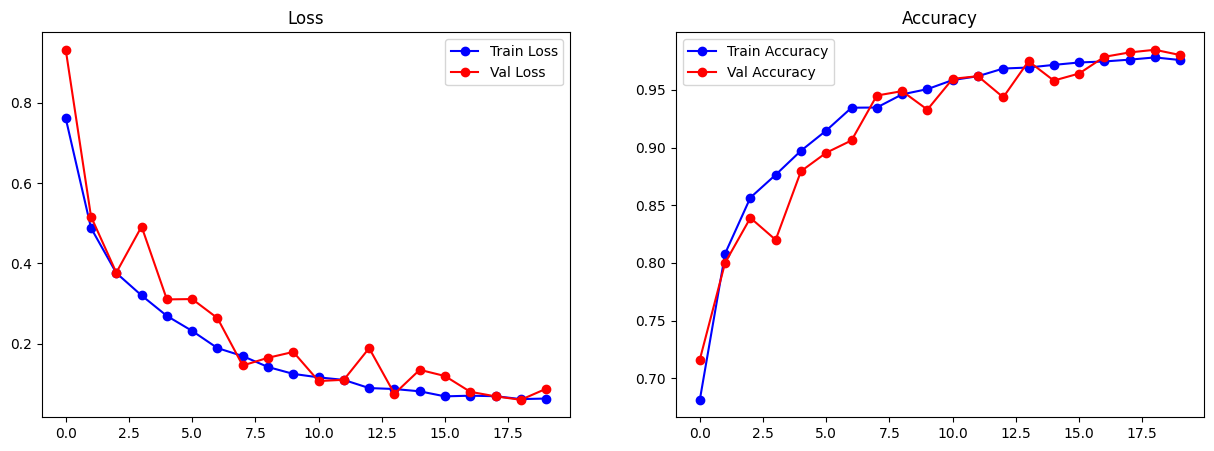

In [ ]:
def create_cnn_model(input_shape=image_shape, num_classes=num_classes):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(512, activation='relu'),
        Dropout(0.5),
        Dense(num_classes, activation='softmax')
    ])
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cnn_model = create_cnn_model()
cnn_history = cnn_model.fit(train_generator, epochs=20, validation_data=test_generator)
plot_curves(cnn_history)

41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
Model Accuracy: 98.01678%
Classification Report for the Model:
              precision    recall  f1-score   support

  meningioma       0.97      0.98      0.98       300
      glioma       0.99      0.93      0.96       306
     notumor       0.98      1.00      0.99       405
   pituitary       0.98      1.00      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



<Figure size 800x800 with 0 Axes>

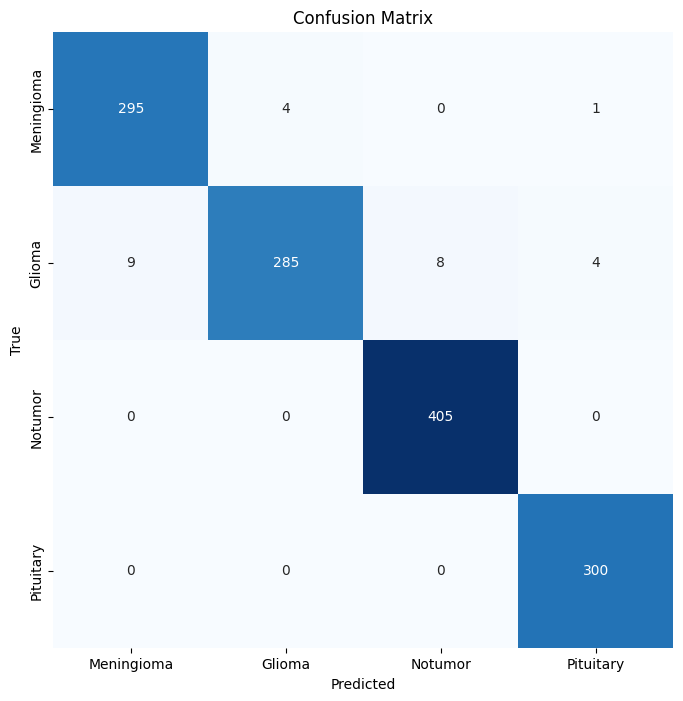

In [ ]:
plt.figure(figsize=(8,8))
y_true = test_generator.classes
y_pred = cnn_model.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)

accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Model Accuracy: {accuracy:.5%}")
report = classification_report(y_true, y_pred_classes, target_names=classes)

print("Classification Report for the Model:")
print(report)
plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=[name.title() for name in classes],
            yticklabels=[name.title() for name in classes])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

#**VGG16 model**

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 79s 368ms/step - accuracy: 0.6864 - loss: 0.7587 - val_accuracy: 0.8497 - val_loss: 0.4164
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 53s 282ms/step - accuracy: 0.8917 - loss: 0.2744 - val_accuracy: 0.9047 - val_loss: 0.2494
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 54s 287ms/step - accuracy: 0.9259 - loss: 0.2050 - val_accuracy: 0.9283 - val_loss: 0.1763
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 50s 266ms/step - accuracy: 0.9447 - loss: 0.1579 - val_accuracy: 0.9512 - val_loss: 0.1297
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 51s 273ms/step - accuracy: 0.9608 - loss: 0.1032 - val_accuracy: 0.9626 - val_loss: 0.1058
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 53s 289ms/step - accuracy: 0.9686 - loss: 0.0904 - val_accuracy: 0.9626 - val_loss: 0.1011
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 51s 275ms/step - accuracy: 0.9731 - loss: 0.0785 - val_accuracy: 0.9741 - val_loss: 0.0746
Epoch 8/20
179/179 ━━━━━━━━━━━━━

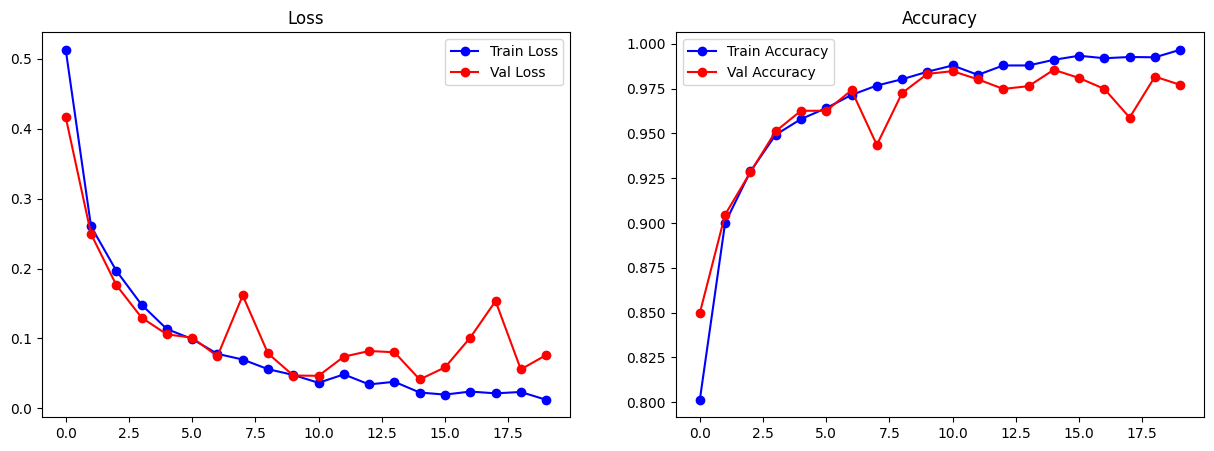

In [ ]:
base_model_vgg = VGG16(weights='imagenet', include_top=False, input_shape=image_shape)
for layer in base_model_vgg.layers[:-4]:
    layer.trainable = False

x = base_model_vgg.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

model_vgg = Model(inputs=base_model_vgg.input, outputs=output)
model_vgg.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

vgg_history = model_vgg.fit(train_generator, epochs=20, validation_data=test_generator)
plot_curves(vgg_history)


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 71ms/step
Model Accuracy: 97.71167%
Classification Report for the Model:
              precision    recall  f1-score   support

  meningioma       1.00      0.93      0.97       300
      glioma       0.94      0.97      0.96       306
     notumor       0.99      1.00      1.00       405
   pituitary       0.98      0.99      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



<Figure size 800x800 with 0 Axes>

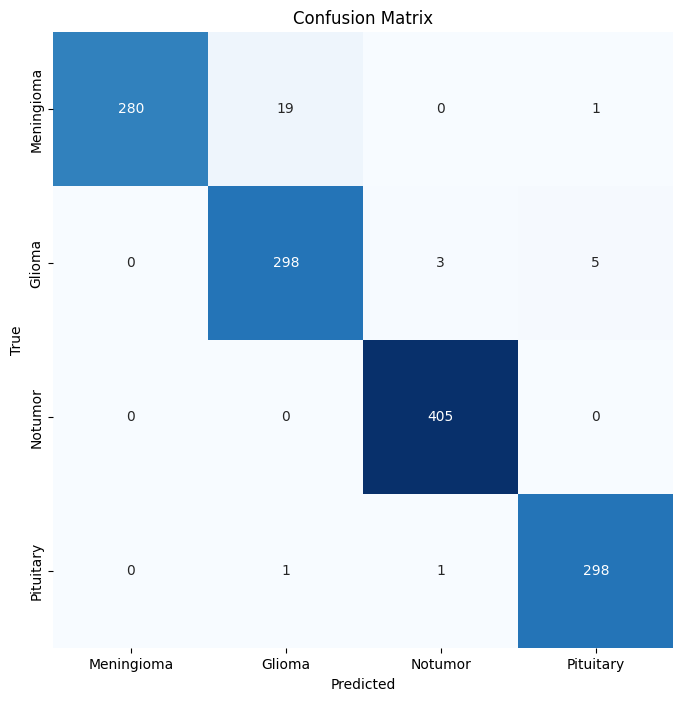

In [ ]:
plt.figure(figsize=(8,8))
y_true = test_generator.classes
y_pred = model_vgg.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)

accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Model Accuracy: {accuracy:.5%}")
report = classification_report(y_true, y_pred_classes, target_names=classes)

print("Classification Report for the Model:")
print(report)

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=[name.title() for name in classes],
            yticklabels=[name.title() for name in classes])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

#**ResNet model**

171446536/171446536 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step
Epoch 1/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 229s 677ms/step - accuracy: 0.8009 - loss: 0.5064 - val_accuracy: 0.3097 - val_loss: 5.2108
Epoch 2/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 97s 361ms/step - accuracy: 0.9514 - loss: 0.1323 - val_accuracy: 0.3135 - val_loss: 4.5835
Epoch 3/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 66s 358ms/step - accuracy: 0.9703 - loss: 0.0795 - val_accuracy: 0.4333 - val_loss: 2.1576
Epoch 4/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 82s 356ms/step - accuracy: 0.9821 - loss: 0.0637 - val_accuracy: 0.5423 - val_loss: 1.4639
Epoch 5/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 67s 363ms/step - accuracy: 0.9907 - loss: 0.0338 - val_accuracy: 0.8337 - val_loss: 0.4571
Epoch 6/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 80s 355ms/step - accuracy: 0.9895 - loss: 0.0338 - val_accuracy: 0.8871 - val_loss: 0.3964
Epoch 7/20
179/179 ━━━━━━━━━━━━━━━━━━━━ 83s 361ms/step - accuracy: 0.9833 - loss: 0.0471 - val_accuracy: 0.9115 - val_loss: 0.3046
Epoch 8/20
179/179 ━━━━━━━━━━

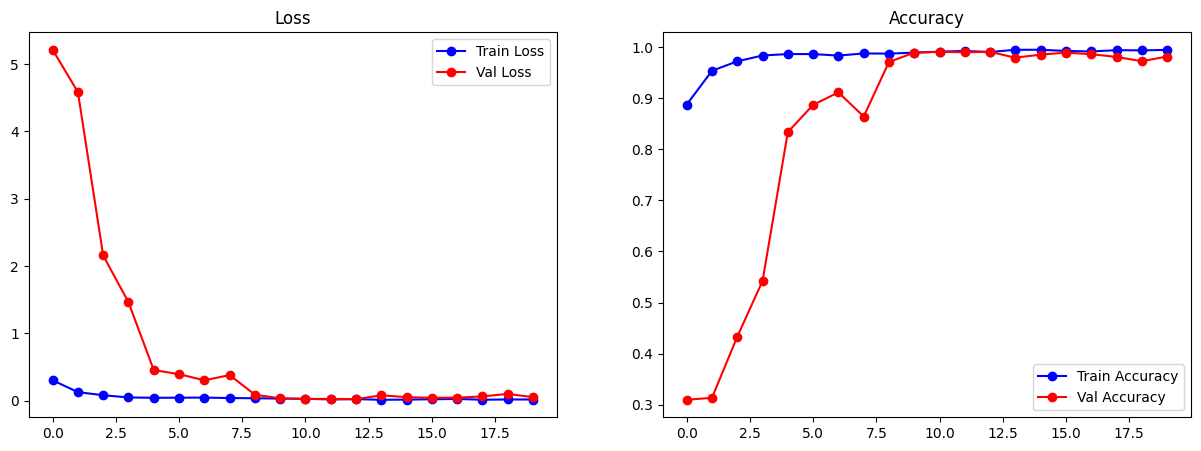

In [ ]:
base_model_resnet = ResNet101(weights='imagenet', include_top=False, input_shape=image_shape)
x = base_model_resnet.output
x = GlobalAveragePooling2D()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation='softmax')(x)

model_resnet = Model(inputs=base_model_resnet.input, outputs=output)
model_resnet.compile(optimizer=Adam(learning_rate=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])

resnet_history = model_resnet.fit(train_generator, epochs=20, validation_data=test_generator)
plot_curves(resnet_history)

41/41 ━━━━━━━━━━━━━━━━━━━━ 16s 234ms/step
Model Accuracy: 98.16934%
Classification Report for the Model:
              precision    recall  f1-score   support

  meningioma       1.00      0.96      0.98       300
      glioma       0.97      0.96      0.97       306
     notumor       0.98      1.00      0.99       405
   pituitary       0.98      1.00      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311



<Figure size 800x800 with 0 Axes>

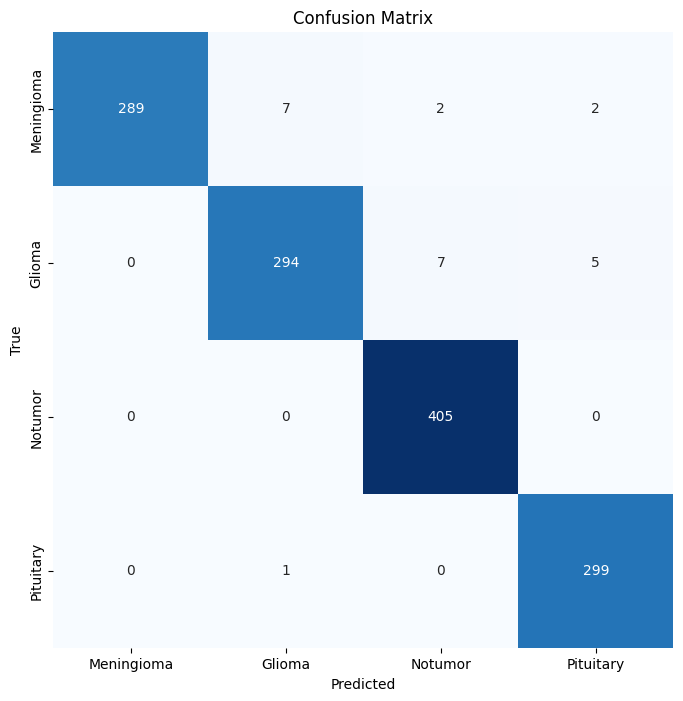

In [ ]:
plt.figure(figsize=(8,8))
y_true = test_generator.classes
y_pred = model_resnet.predict(test_generator)
y_pred_classes = np.argmax(y_pred, axis=1)

conf_matrix = confusion_matrix(y_true, y_pred_classes)

accuracy = accuracy_score(y_true, y_pred_classes)
print(f"Model Accuracy: {accuracy:.5%}")
report = classification_report(y_true, y_pred_classes, target_names=classes)

print("Classification Report for the Model:")
print(report)

plt.figure(figsize=(8, 8))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False,
            xticklabels=[name.title() for name in classes],
            yticklabels=[name.title() for name in classes])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

#**Ensemble Model**

Ensemble Model Classification Report:
              precision    recall  f1-score   support

  meningioma       1.00      0.98      0.99       300
      glioma       0.98      0.98      0.98       306
     notumor       0.99      1.00      1.00       405
   pituitary       0.99      1.00      0.99       300

    accuracy                           0.99      1311
   macro avg       0.99      0.99      0.99      1311
weighted avg       0.99      0.99      0.99      1311



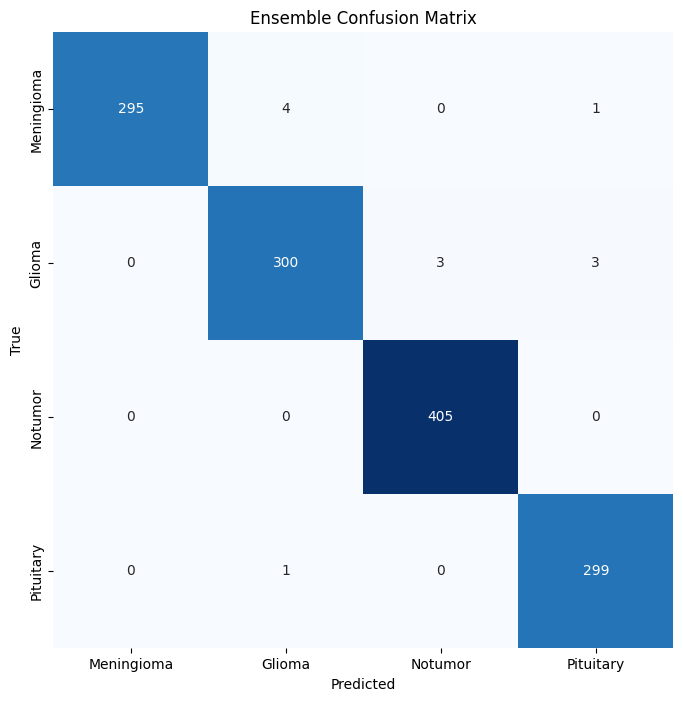

In [ ]:
def ensemble_predictions(models, test_generator):
    model_predictions = [model.predict(test_generator, verbose=0) for model in models]
    average_predictions = np.mean(model_predictions, axis=0)
    final_predictions = np.argmax(average_predictions, axis=1)
    return final_predictions

models = [cnn_model, model_vgg, model_resnet]
true_labels = test_generator.classes

ensemble_preds = ensemble_predictions(models, test_generator)

ensemble_cm = confusion_matrix(true_labels, ensemble_preds)
print("Ensemble Model Classification Report:")
print(classification_report(true_labels, ensemble_preds, target_names=classes))

plt.figure(figsize=(8, 8))
sns.heatmap(ensemble_cm, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.title("Ensemble Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.xticks(ticks=np.arange(len(classes)) + 0.5, labels=[name.title() for name in classes], ha='center')
plt.yticks(ticks=np.arange(len(classes)) + 0.5, labels=[name.title() for name in classes], va='center')
plt.show()


{'meningioma': 0.0, 'glioma': 0.0, 'notumor': 0.0, 'pituitary': 100.0}
{'meningioma': 0.0, 'glioma': 0.0, 'notumor': 0.0, 'pituitary': 100.0}
{'meningioma': 0.0, 'glioma': 0.0, 'notumor': 0.0, 'pituitary': 100.0}
{'meningioma': 0.0, 'glioma': 0.0, 'notumor': 0.0, 'pituitary': 100.0}
{'meningioma': 0.0, 'glioma': 0.0, 'notumor': 0.0, 'pituitary': 100.0}
{'meningioma': 0.0, 'glioma': 0.0, 'notumor': 0.0, 'pituitary': 100.0}
{'meningioma': 0.0, 'glioma': 0.0, 'notumor': 0.0, 'pituitary': 100.0}
{'meningioma': 0.0, 'glioma': 0.0, 'notumor': 0.0, 'pituitary': 100.0}
{'meningioma': 0.0, 'glioma': 0.0, 'notumor': 0.0, 'pituitary': 100.0}
{'meningioma': 0.0, 'glioma': 0.0, 'notumor': 0.0, 'pituitary': 100.0}


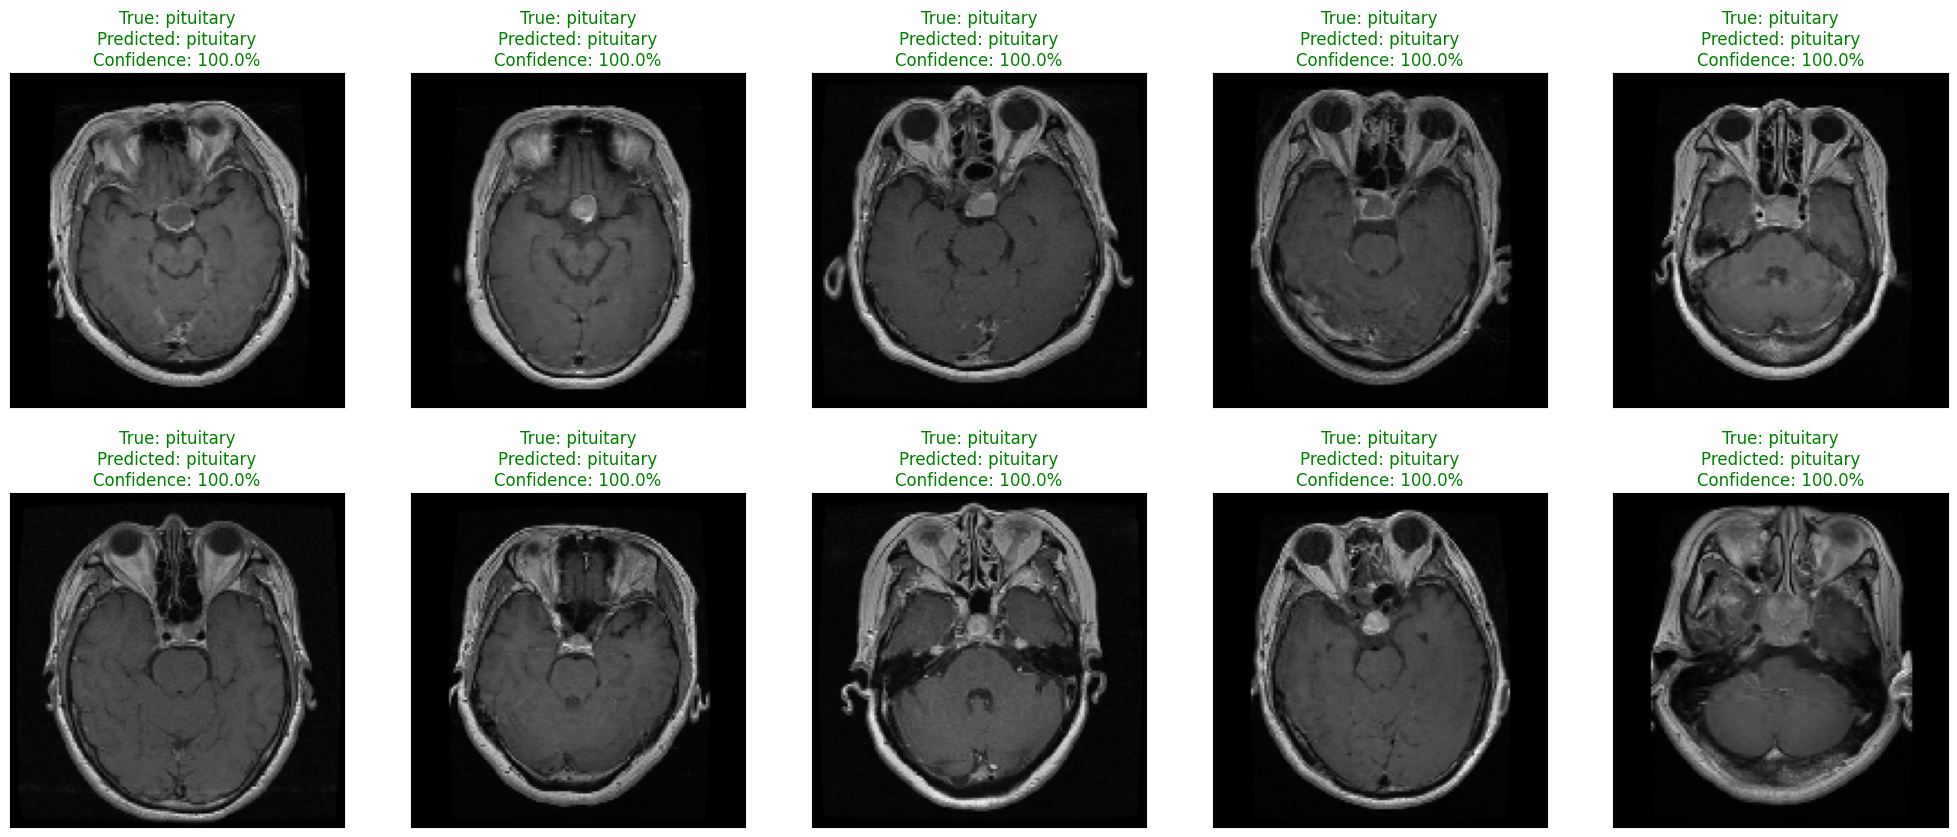

<Figure size 640x480 with 0 Axes>

In [ ]:
Random_batch = np.random.randint(0, len(test_generator))
Random_Img_Index = np.random.randint(0, batch_size , 10)
fig, axes = plt.subplots(nrows=2, ncols=5, figsize=(25, 10),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(axes.flat):
    Random_Img = test_generator[Random_batch][0][Random_Img_Index[i]]
    Random_Img_Label = np.argmax(test_generator[Random_batch][1][Random_Img_Index[i]])
    Model_Predictions = model_resnet.predict( tf.expand_dims(Random_Img, axis=0) , verbose=0)
    Model_Highest_Prediction = np.argmax(Model_Predictions)
    Model_Predictions_Map = { c: round(p*100,3) for (c,p) in zip (classes, Model_Predictions.tolist()[0] ) }
    ax.imshow(Random_Img)
    Pred_Class = classes[Model_Highest_Prediction]
    if classes[Random_Img_Label] == Pred_Class:
      color = "green"
    else:
      color = "red"
    ax.set_title(f"True: {classes[Random_Img_Label]}\nPredicted: {Pred_Class}\nConfidence: {Model_Predictions_Map[Pred_Class]}%",
          color=color)
    print(Model_Predictions_Map)
plt.show()
plt.tight_layout()

In [ ]:
cnn_model.save('cnn_model.keras')
model_vgg.save('vgg_model.keras')
model_resnet.save('resnet_model.keras')

In [ ]:
def ensemble_predict(models, test_generator):
    predictions = [model.predict(test_generator, verbose=0) for model in models]
    avg_prediction = np.mean(predictions, axis=0)
    return np.argmax(avg_prediction, axis=1)

models = [cnn_model, model_vgg, model_resnet]
ensemble_preds = ensemble_predict(models, test_generator)

np.savetxt('ensemble_predictions.csv', ensemble_preds, delimiter=",")


In [ ]:
cnn_model_loaded = tf.keras.models.load_model('cnn_model.keras')
model_vgg_loaded = tf.keras.models.load_model('vgg_model.keras')
model_resnet_loaded = tf.keras.models.load_model('resnet_model.keras')

ensemble_preds = ensemble_predict([cnn_model_loaded, model_vgg_loaded, model_resnet_loaded], test_generator)

/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 12 variables whereas the saved optimizer has 22 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))
/usr/local/lib/python3.10/dist-packages/keras/src/saving/saving_lib.py:713: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 422 variables whereas the saved optimizer has 842 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:
cnn_history_df = pd.DataFrame(cnn_history.history)
cnn_history_df.to_csv('cnn_history.csv', index=False)

vgg_history_df = pd.DataFrame(vgg_history.history)
vgg_history_df.to_csv('vgg_history.csv', index=False)

resnet_history_df = pd.DataFrame(resnet_history.history)
resnet_history_df.to_csv('resnet_history.csv', index=False)

In [ ]:

def save_confusion_matrix(conf_matrix, model_name):
    plt.figure(figsize=(8, 8))
    sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title(f"Confusion Matrix ({model_name})")
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.savefig(f"{model_name}_conf_matrix.png")
    plt.close()


cnn_conf_matrix = confusion_matrix(true_labels, cnn_model.predict(test_generator).argmax(axis=1))
save_confusion_matrix(cnn_conf_matrix, 'cnn')

vgg_conf_matrix = confusion_matrix(true_labels, model_vgg.predict(test_generator).argmax(axis=1))
save_confusion_matrix(vgg_conf_matrix, 'vgg')

resnet_conf_matrix = confusion_matrix(true_labels, model_resnet.predict(test_generator).argmax(axis=1))
save_confusion_matrix(resnet_conf_matrix, 'resnet')

ensemble_conf_matrix = confusion_matrix(true_labels, ensemble_preds)
save_confusion_matrix(ensemble_conf_matrix, 'ensemble')


41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 48ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 2s 60ms/step
41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step


In [ ]:
import tensorflow as tf
import numpy as np
from sklearn.metrics import classification_report


cnn_model_loaded = tf.keras.models.load_model('cnn_model.h5')
model_vgg_loaded = tf.keras.models.load_model('vgg_model.h5')
model_resnet_loaded = tf.keras.models.load_model('resnet_model.h5')

def ensemble_predict(models, test_generator):
    predictions = [model.predict(test_generator, verbose=0) for model in models]
    avg_prediction = np.mean(predictions, axis=0)
    return np.argmax(avg_prediction, axis=1)


def compare_models():
    cnn_preds = cnn_model_loaded.predict(test_generator)
    cnn_preds_classes = np.argmax(cnn_preds, axis=1)
    print("CNN Classification Report:")
    print(classification_report(true_labels, cnn_preds_classes, target_names=classes))

    vgg_preds = model_vgg_loaded.predict(test_generator)
    vgg_preds_classes = np.argmax(vgg_preds, axis=1)
    print("VGG Classification Report:")
    print(classification_report(true_labels, vgg_preds_classes, target_names=classes))

    resnet_preds = model_resnet_loaded.predict(test_generator)
    resnet_preds_classes = np.argmax(resnet_preds, axis=1)
    print("ResNet Classification Report:")
    print(classification_report(true_labels, resnet_preds_classes, target_names=classes))

    ensemble_preds = ensemble_predict([cnn_model_loaded, model_vgg_loaded, model_resnet_loaded], test_generator)
    print("Ensemble Classification Report:")
    print(classification_report(true_labels, ensemble_preds, target_names=classes))

compare_models()


41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 52ms/step
CNN Classification Report:
              precision    recall  f1-score   support

  meningioma       0.97      0.98      0.98       300
      glioma       0.99      0.93      0.96       306
     notumor       0.98      1.00      0.99       405
   pituitary       0.98      1.00      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      1311

41/41 ━━━━━━━━━━━━━━━━━━━━ 3s 68ms/step
VGG Classification Report:
              precision    recall  f1-score   support

  meningioma       1.00      0.93      0.97       300
      glioma       0.94      0.97      0.96       306
     notumor       0.99      1.00      1.00       405
   pituitary       0.98      0.99      0.99       300

    accuracy                           0.98      1311
   macro avg       0.98      0.98      0.98      1311
weighted avg       0.98      0.98      0.98      13

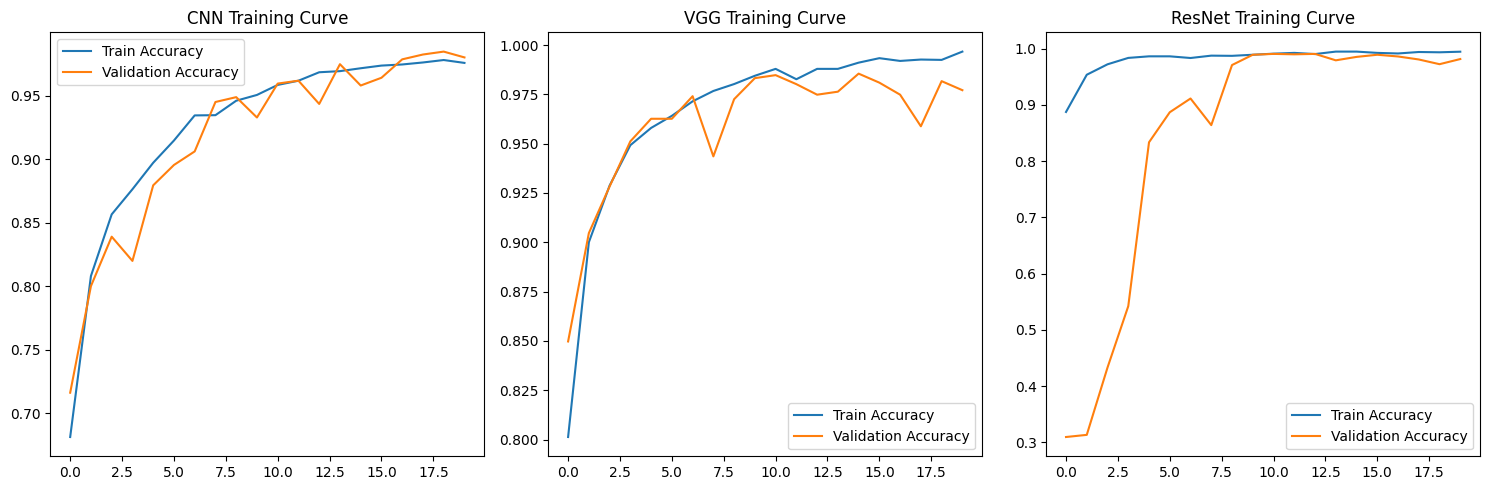

In [ ]:
def compare_training_curves():
    cnn_history = pd.read_csv('cnn_history.csv')
    vgg_history = pd.read_csv('vgg_history.csv')
    resnet_history = pd.read_csv('resnet_history.csv')

    plt.figure(figsize=(15, 5))

    plt.subplot(1, 3, 1)
    plt.plot(cnn_history['accuracy'], label="Train Accuracy")
    plt.plot(cnn_history['val_accuracy'], label="Validation Accuracy")
    plt.title("CNN Training Curve")
    plt.legend()

    plt.subplot(1, 3, 2)
    plt.plot(vgg_history['accuracy'], label="Train Accuracy")
    plt.plot(vgg_history['val_accuracy'], label="Validation Accuracy")
    plt.title("VGG Training Curve")
    plt.legend()

    plt.subplot(1, 3, 3)
    plt.plot(resnet_history['accuracy'], label="Train Accuracy")
    plt.plot(resnet_history['val_accuracy'], label="Validation Accuracy")
    plt.title("ResNet Training Curve")
    plt.legend()

    plt.tight_layout()
    plt.show()

compare_training_curves()
